In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
os.chdir("D:/Study/GreatLearning/7.ComputerVision/Project")

In [3]:
from datetime import datetime
from packaging import version

In [4]:
epochs=10000
batch=15
patience=20

In [5]:
%load_ext tensorboard
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 12432), started 14:49:56 ago. (Use '!kill 12432' to kill it.)

In [6]:
gpu = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpu[0],True)

### Importing Data from *.npy file

In [7]:
data = np.load("D:/Study/GreatLearning/7.ComputerVision/Project/images.npy")

In [8]:
data.shape

(4750, 128, 128, 3)

### Show image from data set

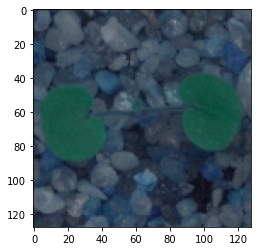

In [9]:
plt.imshow(data[0])

In [10]:
data = data/255.0

### Import labels from CVS file

In [11]:
labels = pd.read_csv("Labels.csv")

In [12]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

In [13]:
labels.iloc[0,:]

Label    Small-flowered Cranesbill
Name: 0, dtype: object

Text(0.5, 1.0, 'Common Chickweed')

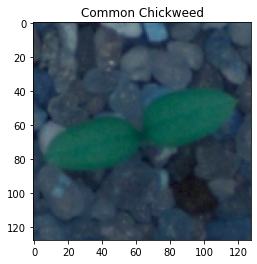

In [14]:
plt.imshow(data[2000])
plt.title(labels.iloc[2000,0])

Text(0.5, 1.0, 'Shepherds Purse')

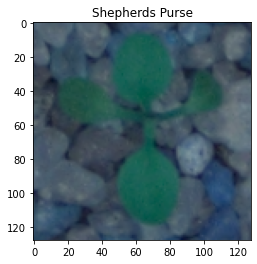

In [15]:
plt.imshow(data[1001])
plt.title(labels.iloc[1001,0])

### Encode Labels

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [17]:
labels_le = le.fit_transform(labels)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [18]:
labels_le

array([10, 10, 10, ...,  6,  6,  6])

In [19]:
le.classes_

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

### Create Train Test and Validation Set

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
xtr, xtsf, ytr, ytsf = train_test_split(data, labels_le, test_size=0.3, stratify=labels_le)

In [22]:
xts, xtv, yts, ytv = train_test_split(xtsf, ytsf, test_size=0.5, stratify=ytsf)

In [23]:
xtr.shape, xtv.shape, xts.shape

((3325, 128, 128, 3), (713, 128, 128, 3), (712, 128, 128, 3))

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1,
    zca_whitening=False,
)

datagen.fit(data)

### RestNet

In [39]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Concatenate, AvgPool2D, Dropout, Flatten, Dense, BatchNormalization, ReLU, Add,GlobalAvgPool2D
from tensorflow.keras.models import Model

In [40]:
def conv_batchnorm_relu(x, filters, kernel_size, strides):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

In [41]:
def identity_block(tensor, filters):
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=1)
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)  # notice: filters=4*filters
    x = BatchNormalization()(x)
 
    x = Add()([x, tensor])
    x = ReLU()(x)
    return x

In [42]:
def projection_block(tensor, filters, strides):
    # left stream
    x = conv_batchnorm_relu(tensor, filters=filters, kernel_size=1, strides=strides) #[v]
    x = conv_batchnorm_relu(x, filters=filters, kernel_size=3, strides=1)
    x = Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)  # notice: filters=4*filters
    x = BatchNormalization()(x)
 
    # right stream
    shortcut = Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)  # notice: filters=4*filters
    shortcut = BatchNormalization()(shortcut)
 
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [43]:
def resnet_block(x, filters, reps, strides):
    x = projection_block(x, filters=filters, strides=strides)
    for _ in range(reps-1):
        x = identity_block(x, filters=filters)
    return x

In [44]:
input_ = Input(shape=xtr.shape[1:])
 
x = conv_batchnorm_relu(input_, filters=64, kernel_size=7, strides=2)  # [3]: 7x7, 64, strides 2
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)  # [3]: 3x3 max mool, strides 2
 
x = resnet_block(x, filters=64, reps=3, strides=1)
x = resnet_block(x, filters=128, reps=4, strides=2)  # strides=2 ([2]: conv3_1)
x = resnet_block(x, filters=256, reps=6, strides=2)  # strides=2 ([2]: conv4_1)
x = resnet_block(x, filters=512, reps=3, strides=2)  # strides=2 ([2]: conv5_1)
 
x = GlobalAvgPool2D()(x)  # [3]: average pool *it is not written any pool size so we use Global
 
output_ = Dense(12, activation='softmax')(x)  # [3]: 1000-d fc, softmax
 
from tensorflow.keras import Model
 
resnet50 = Model(input_, output_)

In [45]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = tf. keras.callbacks.TensorBoard(log_dir=logdir)
es_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

In [52]:
resnet50.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [53]:
history = resnet50.fit(datagen.flow(xtr,ytr,batch_size=batch), epochs=epochs, validation_data=(xtv, ytv), callbacks=[tb_cb,es_cb], steps_per_epoch=len(xtr) // batch)

Epoch 1/10000
221/221 [==============================] - 27s 104ms/step - loss: 0.3402 - accuracy: 0.8912 - val_loss: 0.9802 - val_accuracy: 0.6746
Epoch 2/10000
221/221 [==============================] - 14s 64ms/step - loss: 0.3966 - accuracy: 0.8669 - val_loss: 1.5696 - val_accuracy: 0.5989
Epoch 3/10000
221/221 [==============================] - 14s 64ms/step - loss: 0.3148 - accuracy: 0.8937 - val_loss: 0.9638 - val_accuracy: 0.7798
Epoch 4/10000
221/221 [==============================] - 14s 65ms/step - loss: 0.2975 - accuracy: 0.8937 - val_loss: 0.8770 - val_accuracy: 0.7209
Epoch 5/10000
221/221 [==============================] - 14s 65ms/step - loss: 0.3019 - accuracy: 0.8928 - val_loss: 17.0099 - val_accuracy: 0.1571
Epoch 6/10000
221/221 [==============================] - 14s 65ms/step - loss: 0.4016 - accuracy: 0.8655 - val_loss: 1.2720 - val_accuracy: 0.7433
Epoch 7/10000
221/221 [==============================] - 14s 65ms/step - loss: 0.2894 - accuracy: 0.9014 - val_loss:

In [54]:
resnet50.evaluate(xts,yts)

23/23 [==============================] - 1s 24ms/step - loss: 0.3373 - accuracy: 0.9017


[0.3372780382633209, 0.9016854166984558]

In [55]:
resnet50.save("Model_6_ResNet50")

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2342: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1395: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: Model_6_ResNet50\assets


Text(0.5, 1.0, 'Train_Accuracy vs Validation_Accuracy')

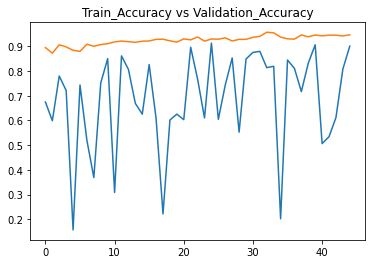

In [56]:
pd.DataFrame(history.history).iloc[:,3].plot()
pd.DataFrame(history.history).iloc[:,1].plot()
plt.title("Train_Accuracy vs Validation_Accuracy")